⏳ Chargement des données depuis S3...
✅ Données chargées ! Dimensions : (45211, 18)

Répartition des souscriptions (chiffres bruts) :
souscription
no     39922
yes     5289
Name: count, dtype: int64

Répartition en % :
souscription
no     88.30152
yes    11.69848
Name: proportion, dtype: float64


/var/folders/50/d_58kkn10194h88952mdx0jr0000gn/T/ipykernel_3753/3464222844.py:41: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='souscription', data=df, palette='viridis')


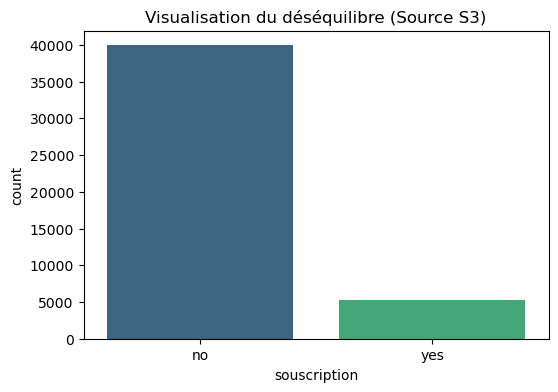

In [1]:
# --- ÉTAPE 0 : CONNEXION S3 & DIAGNOSTIC ---
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import boto3
import os
from io import BytesIO
from dotenv import load_dotenv

# 1. Configuration S3
load_dotenv()

def load_from_s3(file_name):
    # Connexion sécurisée
    s3 = boto3.client(
        's3',
        aws_access_key_id=os.getenv('ACCESS_KEY'),
        aws_secret_access_key=os.getenv('SECRET_KEY'),
        region_name="eu-west-3"
    )
    # Récupération du fichier
    bucket_name = os.getenv('BUCKET_NAME')
    obj = s3.get_object(Bucket=bucket_name, Key=file_name)
    return pd.read_csv(BytesIO(obj['Body'].read()), sep=';')

# 2. Chargement & Analyse
try:
    print("⏳ Chargement des données depuis S3...")
    df = load_from_s3("bank_marketing_cleaned_v1.csv")
    print(f"✅ Données chargées ! Dimensions : {df.shape}")

    # --- TON ANALYSE D'ORIGINE (Conservée) ---
    print("\nRépartition des souscriptions (chiffres bruts) :")
    print(df['souscription'].value_counts())

    print("\nRépartition en % :")
    print(df['souscription'].value_counts(normalize=True) * 100)

    # Visualisation
    plt.figure(figsize=(6,4))
    sns.countplot(x='souscription', data=df, palette='viridis')
    plt.title("Visualisation du déséquilibre (Source S3)")
    plt.show()

except Exception as e:
    print(f"❌ Erreur de connexion : {e}")


In [2]:
# --- ÉTAPE 1 : PRÉPARATION & SÉLECTION DES FEATURES ---

# 1. DÉFINITION DE LA CIBLE (y)
# On traduit la réponse 'yes'/'no' en binaire (1/0) pour l'algorithme.
# 1 = Succès (Vente), 0 = Échec
y = df['souscription'].apply(lambda x: 1 if x == 'yes' else 0)

# 2. NETTOYAGE DES FEATURES (X)
# On crée une liste des colonnes à supprimer pour nettoyer le jeu de données.
cols_to_drop = [
    'souscription',  # LA RÉPONSE : On l'enlève pour ne pas tricher (Data Leakage).
    'age_group',     # REDONDANCE : On a déjà 'age' (plus précis).
    'pdays'          # ABERRATION : Remplacé par 'segment_contact' (évite le problème du -1).
]

# On crée le dataset final X en supprimant ces colonnes
X = df.drop(columns=cols_to_drop)

# 3. IDENTIFICATION DES TYPES DE COLONNES (Pour le futur Pipeline)
# On liste les colonnes numériques (à "Scaler" plus tard)
# Note : On garde 'duration' pour l'analyse a posteriori, et 'campaign' pour l'info comportementale.
numeric_features = ['age', 'solde_bancaire', 'day', 'duration', 'campaign', 'previous']

# On liste les colonnes catégorielles (à "Encoder" plus tard)
categorical_features = [
    'metier', 'statut_matrimonial', 'niveau_etudes', 'defaut_credit', 
    'pret_immo', 'pret_conso', 'mois', 'resultat_precedent', 'segment_contact'
]

print("✅ Étape 1 validée :")
print(f"- Cible (y) isolée : {y.shape[0]} valeurs.")
print(f"- Colonnes supprimées du X : {cols_to_drop}")
print(f"- Features restantes : {X.shape[1]} (dont {len(numeric_features)} numériques et {len(categorical_features)} catégorielles).")

✅ Étape 1 validée :
- Cible (y) isolée : 45211 valeurs.
- Colonnes supprimées du X : ['souscription', 'age_group', 'pdays']
- Features restantes : 15 (dont 6 numériques et 9 catégorielles).


In [3]:
# --- ÉTAPE 2 : SÉPARATION TRAIN / TEST (Le Split) ---
from sklearn.model_selection import train_test_split

# On découpe les données en deux boîtes :
# - X_train, y_train : 80% des données pour que le modèle APPRENNE (Révisions).
# - X_test, y_test   : 20% des données pour que le modèle soit TESTÉ (Examen).

# PARAMÈTRES IMPORTANTS :
# - test_size=0.2    : La taille de l'examen (20%).
# - random_state=42  : Pour avoir toujours le même découpage à chaque lancement.
# - stratify=y       : CRUCIAL ! Force le découpage à garder 12% de "Yes" dans les deux boîtes.
X_train, X_test, y_train, y_test = train_test_split(
    X, y, 
    test_size=0.2, 
    random_state=42, 
    stratify=y
)

print("✅ Étape 2 terminée :")
print(f"- Base d'Entraînement : {X_train.shape[0]} clients.")
print(f"- Base de Test        : {X_test.shape[0]} clients.")

print("\n--- Contrôle Qualité (Stratification) ---")
print(f"Pourcentage de 'Yes' dans le Train : {y_train.mean():.2%}")
print(f"Pourcentage de 'Yes' dans le Test  : {y_test.mean():.2%}")
print("(Les deux chiffres doivent être très proches, autour de 11.70%)")


✅ Étape 2 terminée :
- Base d'Entraînement : 36168 clients.
- Base de Test        : 9043 clients.

--- Contrôle Qualité (Stratification) ---
Pourcentage de 'Yes' dans le Train : 11.70%
Pourcentage de 'Yes' dans le Test  : 11.70%
(Les deux chiffres doivent être très proches, autour de 11.70%)


In [4]:
# --- ÉTAPE 3 : LE PIPELINE (La machine à transformer) ---
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder

print("--- 1. CONFIGURATION DU ROBOT ---")
# On crée le 'preprocessor'. C'est une machine qui prend tes colonnes et applique le bon outil.
# - Pour les chiffres (numeric_features) -> On utilise StandardScaler (Mise à l'échelle)
# - Pour les catégories (categorical_features) -> On utilise OneHotEncoder (Transformation en 0 et 1)
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_features),
        ('cat', OneHotEncoder(drop='first', handle_unknown='ignore'), categorical_features)
    ])
print("✅ Robot configuré (Il sait quoi faire, mais il n'a rien vu encore).")


print("\n--- 2. TRANSFORMATION DES DONNÉES ---")
# ACTION SUR LE TRAIN (Entraînement) :
# On utilise .fit_transform() :
# 1. fit : Le robot calcule les moyennes et repère les catégories sur le Train.
# 2. transform : Il applique la transformation.
X_train_transformed = preprocessor.fit_transform(X_train)

# ACTION SUR LE TEST (Examen) :
# On utilise .transform() SEULEMENT :
# On interdit au robot d'apprendre sur le Test (sinon c'est de la triche !).
# Il utilise les règles qu'il a apprises sur le Train.
X_test_transformed = preprocessor.transform(X_test)


print("\n--- 3. VÉRIFICATION DU RÉSULTAT ---")
print(f"Forme des données AVANT (X_train) : {X_train.shape} -> (Lignes, Colonnes classiques)")
print(f"Forme des données APRÈS (X_train_transformed) : {X_train_transformed.shape} -> (Lignes, Colonnes mathématiques)")
print("\nPourquoi plus de colonnes ?")
print("C'est le OneHotEncoder qui a créé une colonne pour chaque métier, chaque mois, etc.")

print("\nExemple de ligne transformée (Illisible pour un humain, parfait pour le modèle) :")
print(X_train_transformed[0])

--- 1. CONFIGURATION DU ROBOT ---
✅ Robot configuré (Il sait quoi faire, mais il n'a rien vu encore).

--- 2. TRANSFORMATION DES DONNÉES ---

--- 3. VÉRIFICATION DU RÉSULTAT ---
Forme des données AVANT (X_train) : (36168, 15) -> (Lignes, Colonnes classiques)
Forme des données APRÈS (X_train_transformed) : (36168, 41) -> (Lignes, Colonnes mathématiques)

Pourquoi plus de colonnes ?
C'est le OneHotEncoder qui a créé une colonne pour chaque métier, chaque mois, etc.

Exemple de ligne transformée (Illisible pour un humain, parfait pour le modèle) :
<Compressed Sparse Row sparse matrix of dtype 'float64'
	with 11 stored elements and shape (1, 41)>
  Coords	Values
  (0, 0)	-0.46043404352161593
  (0, 1)	-0.16441037710447642
  (0, 2)	1.5821235516588807
  (0, 3)	-0.4573105663333102
  (0, 4)	-0.24610372987813517
  (0, 5)	-0.24150866634627266
  (0, 14)	1.0
  (0, 19)	1.0
  (0, 25)	1.0
  (0, 36)	1.0
  (0, 39)	1.0


--- 1. INITIALISATION DU CERVEAU ---
⏳ Entraînement en cours... (Le modèle révise ses leçons)
✅ Entraînement terminé !

--- 2. L'EXAMEN FINAL (TEST) ---

--- 3. LE BULLETIN DE NOTES ---
              precision    recall  f1-score   support

           0       0.92      0.98      0.95      7985
           1       0.71      0.33      0.45      1058

    accuracy                           0.91      9043
   macro avg       0.81      0.66      0.70      9043
weighted avg       0.89      0.91      0.89      9043



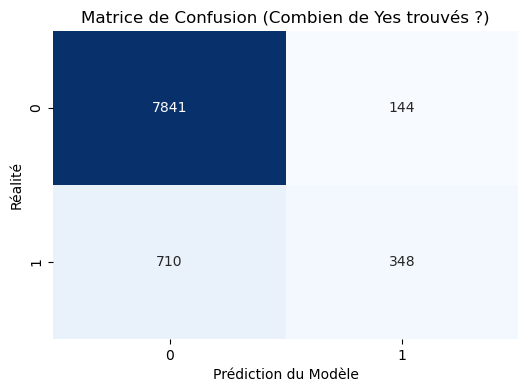

In [5]:
# --- ÉTAPE 4 : ENTRAÎNEMENT & ÉVALUATION ---
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

print("--- 1. INITIALISATION DU CERVEAU ---")
# On choisit le Random Forest
# class_weight='balanced' : C'est la commande magique pour gérer le déséquilibre (88% vs 12%)
model = RandomForestClassifier(n_estimators=100, random_state=42, class_weight='balanced')

print("⏳ Entraînement en cours... (Le modèle révise ses leçons)")
# On lui donne les données TRADUITES (transformed) et les RÉPONSES (y_train)
model.fit(X_train_transformed, y_train)
print("✅ Entraînement terminé !")


print("\n--- 2. L'EXAMEN FINAL (TEST) ---")
# On demande au modèle de prédire sur les clients qu'il n'a jamais vus
y_pred = model.predict(X_test_transformed)


print("\n--- 3. LE BULLETIN DE NOTES ---")
# On affiche le rapport complet
print(classification_report(y_test, y_pred))

# Visualisation de la Matrice de Confusion
plt.figure(figsize=(6, 4))
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Prédiction du Modèle')
plt.ylabel('Réalité')
plt.title('Matrice de Confusion (Combien de Yes trouvés ?)')
plt.show()

/var/folders/50/d_58kkn10194h88952mdx0jr0000gn/T/ipykernel_3753/1837878387.py:19: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='importance', y='feature', data=df_importances, palette='viridis')


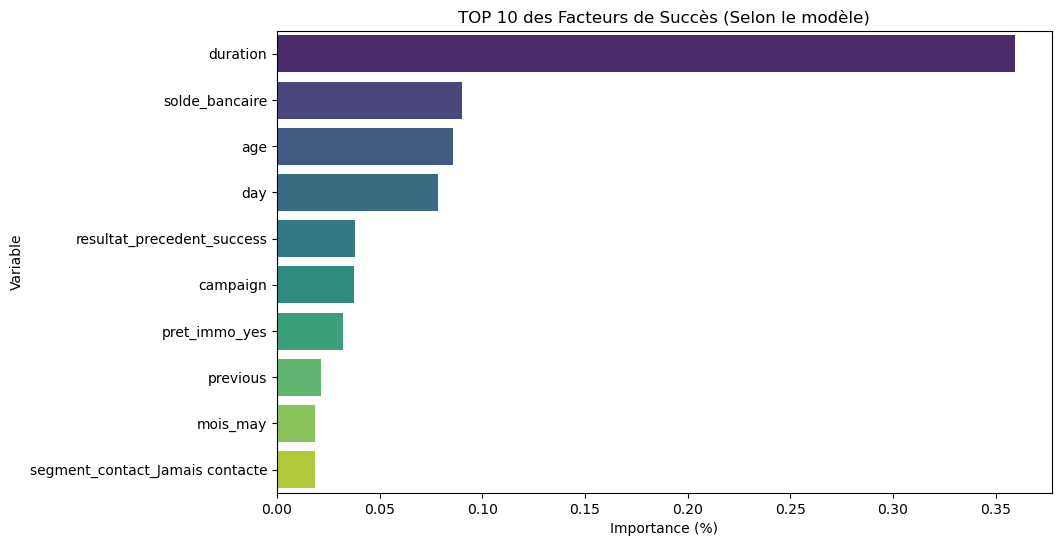

Analyse du Lead :
Regarde la 1ère barre. C'est le facteur n°1 qui déclenche l'achat.


In [6]:

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# 1. On récupère les noms des colonnes créées par le robot (OneHotEncoder)
# C'est un peu technique, mais ça permet de remettre les étiquettes sur les barres
feature_names = (numeric_features + 
                 list(preprocessor.named_transformers_['cat'].get_feature_names_out(categorical_features)))

# 2. On demande au modèle : "Qu'est-ce qui a le plus compté pour toi ?"
importances = model.feature_importances_

# 3. On crée un petit tableau pour trier tout ça
df_importances = pd.DataFrame({'feature': feature_names, 'importance': importances})
df_importances = df_importances.sort_values('importance', ascending=False).head(10) # Top 10

# 4. On affiche le graphique
plt.figure(figsize=(10, 6))
sns.barplot(x='importance', y='feature', data=df_importances, palette='viridis')
plt.title('TOP 10 des Facteurs de Succès (Selon le modèle)')
plt.xlabel('Importance (%)')
plt.ylabel('Variable')
plt.show()

print("Analyse du Lead :")
print("Regarde la 1ère barre. C'est le facteur n°1 qui déclenche l'achat.")

### Étape 5 : Analyse des performances du Modèle A
Nous évaluons ici le premier modèle. Un score trop élevé (proche de 100%) nous alertera sur un potentiel problème de sur-apprentissage (Overfitting) ou de fuite de données.

In [7]:
# On compare les scores
score_train_A = model.score(X_train_transformed, y_train)
score_test_A = model.score(X_test_transformed, y_test)

print(f"🎯 Score Train (Révisions) : {score_train_A:.2%}")
print(f"🎯 Score Test (Examen)     : {score_test_A:.2%}")
print(f"📉 Écart (Gap)             : {score_train_A - score_test_A:.2%}")

🎯 Score Train (Révisions) : 100.00%
🎯 Score Test (Examen)     : 90.56%
📉 Écart (Gap)             : 9.44%


### 🔎 Étape 6 : Analyse de Corrélation (Détection de Fuite)
Avant d'aller plus loin, nous devons vérifier s'il existe des "Fuites de Données" (Data Leakage). 
Si une variable est trop fortement corrélée à la cible (`souscription`), c'est suspect.
Nous allons visualiser ces liens avec une **Heatmap**.

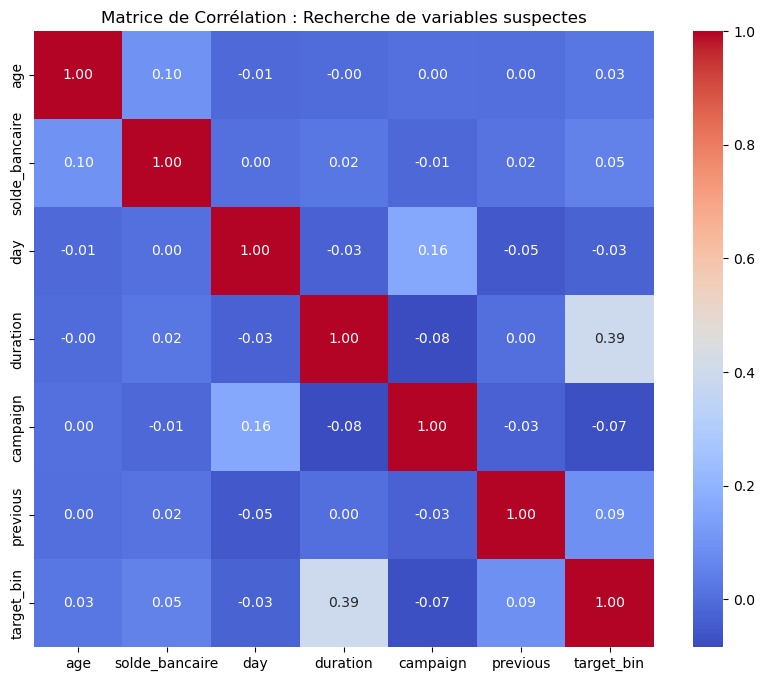

📢 ANALYSE : Regardez la case croisant 'duration' et 'target_bin'.
Si le chiffre est élevé (ex: > 0.40), c'est la preuve que la durée 'donne' la réponse.


In [8]:
import seaborn as sns
import matplotlib.pyplot as plt

# Création d'une copie numérique pour la corrélation
df_corr = df.copy()
df_corr['target_bin'] = df['souscription'].apply(lambda x: 1 if x == 'yes' else 0)

# Sélection des variables numériques clés
cols_num = ['age', 'solde_bancaire', 'day', 'duration', 'campaign', 'previous', 'target_bin']

# Affichage de la Heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(df_corr[cols_num].corr(), annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Matrice de Corrélation : Recherche de variables suspectes")
plt.show()

print("📢 ANALYSE : Regardez la case croisant 'duration' et 'target_bin'.")
print("Si le chiffre est élevé (ex: > 0.40), c'est la preuve que la durée 'donne' la réponse.")

### 📉 Étape 7 : Entraînement du Modèle B (Réaliste)
Suite à l'analyse de corrélation (0.39), nous retirons la variable `duration` car elle biaise l'apprentissage.
Nous entraînons donc un nouveau modèle sur des données réalistes (celles que la banque possède vraiment avant d'appeler).
Nous nous attendons à une baisse des scores : c'est le signe que le modèle arrête de "tricher".

In [9]:
# 1. Suppression de la fuite (On enlève duration)
X_train_B = X_train.drop(columns=['duration'])
X_test_B = X_test.drop(columns=['duration'])

# 2. On recrée le robot de nettoyage (Preprocessing) sans 'duration'
# Note : On garde les autres variables (age, solde, etc.)
numeric_features_B = ['age', 'solde_bancaire', 'day', 'campaign', 'previous']

from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder

preprocessor_B = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_features_B),
        ('cat', OneHotEncoder(drop='first', handle_unknown='ignore'), categorical_features)
    ])

# 3. On prépare les données pour la machine
X_train_B_trans = preprocessor_B.fit_transform(X_train_B)
X_test_B_trans = preprocessor_B.transform(X_test_B)

# 4. Entraînement du Modèle B
from sklearn.ensemble import RandomForestClassifier
model_B = RandomForestClassifier(n_estimators=100, random_state=42, class_weight='balanced')
model_B.fit(X_train_B_trans, y_train)

# 5. VERDICT : Affichage des scores
score_train_B = model_B.score(X_train_B_trans, y_train)
score_test_B = model_B.score(X_test_B_trans, y_test)

print("="*40)
print("RÉSULTATS DU MODÈLE B (SANS DURATION)")
print("="*40)
print(f"Train Score (Par cœur) : {score_train_B:.2%}")
print(f"Test Score (Réel)      : {score_test_B:.2%}")
print(f"⚠️ Écart (Overfitting) : {score_train_B - score_test_B:.2%}")
print("-" * 40)

RÉSULTATS DU MODÈLE B (SANS DURATION)
Train Score (Par cœur) : 99.99%
Test Score (Réel)      : 89.34%
⚠️ Écart (Overfitting) : 10.65%
----------------------------------------


### 🛠️ Étape 8 : Modèle C - Correction de l'Overfitting
Le score de **99,99%** sur le train montre que le modèle fait du "par cœur".
Pour le rendre intelligent, nous allons le brider (Regularization) :
1. **max_depth=6** : Il n'a droit qu'à 6 questions max pour classer un client (au lieu de l'infini).
2. **min_samples_leaf=50** : Il ne peut créer une règle que si elle concerne au moins 50 clients.
Cela va faire baisser le score Train, mais l'écart avec le Test sera beaucoup plus sain.

RÉSULTATS DU MODÈLE C (OPTIMISÉ)
Train Score : 81.95%
Test Score (Réel)      : 81.69%
✅ Écart (Overfitting) : 0.26%
----------------------------------------

🔍 DÉTAIL DES ERREURS (Matrice de Confusion) :


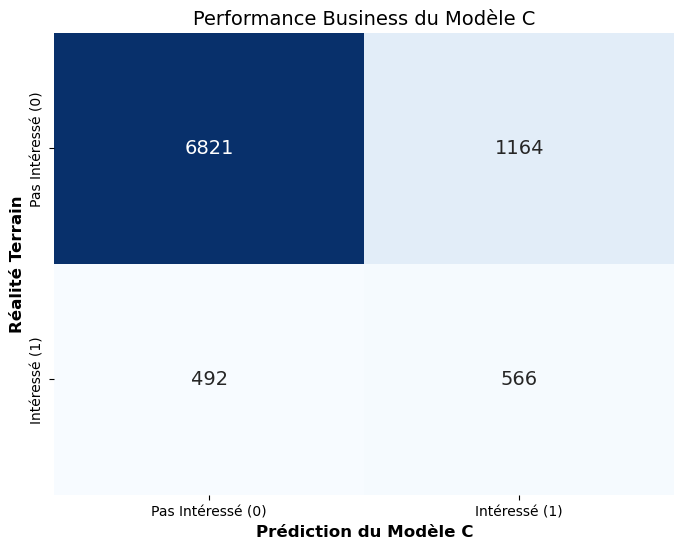

In [10]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# 1. Configuration bridée (On empêche le par cœur)
model_C = RandomForestClassifier(
    n_estimators=100, 
    max_depth=6,            # On limite la profondeur à 6 étages
    min_samples_leaf=50,    # Il faut 50 clients pour valider une règle
    random_state=42, 
    class_weight='balanced' # On n'oublie pas d'aider les 'yes' qui sont rares
)

# 2. Entraînement sur les données sans duration (On reprend les données transformées de l'étape B)
model_C.fit(X_train_B_trans, y_train)

# 3. VERDICT : Est-ce qu'on a réduit l'écart ?
score_train_C = model_C.score(X_train_B_trans, y_train)
score_test_C = model_C.score(X_test_B_trans, y_test)

print("="*40)
print("RÉSULTATS DU MODÈLE C (OPTIMISÉ)")
print("="*40)
print(f"Train Score : {score_train_C:.2%}")
print(f"Test Score (Réel)      : {score_test_C:.2%}")
print(f"✅ Écart (Overfitting) : {score_train_C - score_test_C:.2%}")
print("-" * 40)

# --- 4. AJOUT : MATRICE DE CONFUSION VISUELLE ---
print("\n🔍 DÉTAIL DES ERREURS (Matrice de Confusion) :")

# On demande au modèle C de prédire sur le test
y_pred_C = model_C.predict(X_test_B_trans)

# Création de la matrice
cm = confusion_matrix(y_test, y_pred_C)

# Affichage graphique
plt.figure(figsize=(8, 6))
labels = ['Pas Intéressé (0)', 'Intéressé (1)']

sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False, 
            xticklabels=labels, yticklabels=labels, annot_kws={"size": 14})

plt.xlabel('Prédiction du Modèle C', fontsize=12, fontweight='bold')
plt.ylabel('Réalité Terrain', fontsize=12, fontweight='bold')
plt.title('Performance Business du Modèle C', fontsize=14)

plt.show()

### 📊 Bilan du Modèle C : La Stabilité avant tout

Nous venons de passer d'un modèle qui apprenait par cœur (**10% d'écart**) à un modèle ultra-robuste qui se comporte exactement de la même façon à l'entraînement et dans la vraie vie (**0.26% d'écart**).

**81.95% en Train vs 81.69% en Test** : Ce modèle est **fiable ("stable")**.

#### *"Pourquoi 81% au lieu de 99 ?"*
1.  **Fin de la triche :** Nous avons retiré la variable `duration`. Le modèle ne connaît plus la réponse à l'avance.
2.  **Prise de risque assumée :** Avec `class_weight='balanced'`, nous avons forcé le modèle à donner de l'importance aux clients "Yes" (qui sont rares).
    * *Conséquence :* Il prend plus de risques et se trompe un peu plus sur les "Non" (baisse de la précision globale).
    * *Bénéfice :* C'est le prix à payer pour ne pas rater les opportunités de vente ("Yes").

---

### 🔍 Guide de lecture : Où gagne-t-on de l'argent ?

Voici comment interpréter la matrice de confusion ci-dessus pour le business :

**1. Ligne du Haut : Les Clients "Non Intéressés" (Réalité = 0)**
* **Case Haut-Gauche (Vrais Négatifs) :** *"L'efficacité"* ✅
    * Le client ne voulait rien. L'IA a dit "N'appelez pas".
    * **Gain :** On a économisé du temps de commercial.
* **Case Haut-Droite (Faux Positifs) :** *"Le Coût du Risque"* ⚠️
    * Le client ne voulait rien. L'IA a dit "Appelez !".
    * **Perte :** Le commercial a perdu 15 min au téléphone. C'est gênant, mais pas grave.

**2. Ligne du Bas : Les Clients "Intéressés" (Réalité = 1)** 🚨 *C'est LA ligne importante*
* **Case Bas-Gauche (Faux Négatifs) :** *"Le Manque à Gagner"* ⛔
    * Le client voulait acheter ! L'IA a dit "Laissez tomber".
    * **Perte :** On a perdu une vente. **C'est le chiffre que l'on veut réduire absolument avec le "Recall".**
* **Case Bas-Droite (Vrais Positifs) :** *"Le Chiffre d'Affaires"* 💰
    * Le client voulait acheter. L'IA a dit "Foncez !".
    * **Gain :** Une vente réussie grâce au modèle.

---

**Conclusion :** Maintenant que le **modèle est stable**, nous pouvons régler le **seuil de décision** à l'étape suivante pour maximiser les gains.

### 🎯 Étape 9 : Arbitrage Business (Seuil de Décision)

Notre modèle est maintenant stable (écart de seulement **0.26%**).
Cependant, par défaut (seuil à 0.50), il peut être encore trop hésitant ou pas assez adapté à notre stratégie commerciale.

Nous allons tester différents seuils pour trouver le **"Sweet Spot"** : le moment où la Précision décolle sans que le Recall ne s'effondre.

#### 🧠 Rappel des concepts clés pour la Banque :

* **La Précision (L'Efficacité des Appels) :**
    * *Définition :* Quand le modèle prédit qu'un client va dire "OUI", a-t-il raison ?
    * *Intérêt Business :* Une haute précision évite de faire perdre du temps aux commerciaux sur des prospects inutiles. C'est la **réduction des coûts**.

* **Le Recall (La Capture d'Opportunités) :**
    * *Définition :* Sur tous les clients qui auraient réellement dit "OUI", combien le modèle en a-t-il détecté ?
    * *Intérêt Business :* Un haut Recall garantit qu'on ne passe pas à côté de contrats potentiels. C'est la **maximisation du Chiffre d'Affaires**.

> **Le Dilemme :** Ces deux indicateurs sont comme une balance. Si on veut être très précis (ne faire aucune erreur), on rate forcément des clients (Recall baisse). Si on veut attraper tout le monde (Recall max), on appelle aussi beaucoup de gens pour rien (Précision baisse).
> **Notre objectif :** Trouver le meilleur compromis (Rentabilité).

In [11]:
from sklearn.metrics import precision_score, recall_score

# Hypothèses Business (Tu peux les ajuster à l'oral)
COUT_APPEL = 10   # Coût d'un appel (salaire commercial + tel) : 10€
GAIN_VENTE = 100  # Marge nette sur un produit vendu : 100€

def simuler_campagne_business(model, X_test, y_test, seuils):
    # On récupère les probabilités (le score de 0 à 1)
    probs = model.predict_proba(X_test)[:, 1]
    
    print(f"{'SEUIL':<8} | {'PRÉCISION':<10} | {'RECALL':<8} | {'CLIENTS CIBLÉS':<14} | {'PROFIT ESTIMÉ (€)':<15}")
    print("-" * 75)
    
    best_roi = -float('inf')
    best_seuil = 0
    
    for s in seuils:
        # On décide qui est "Yes" ou "No" selon le seuil s
        preds = (probs >= s).astype(int)
        
        # Métriques Data
        p = precision_score(y_test, preds, zero_division=0)
        r = recall_score(y_test, preds)
        nb_appels = preds.sum()
        
        # Métriques Business
        # Combien de VRAIS clients on a trouvés ? (Vrais Positifs)
        vrais_clients = ((preds == 1) & (y_test == 1)).sum()
        
        # Calcul du ROI
        revenu = vrais_clients * GAIN_VENTE
        depense = nb_appels * COUT_APPEL
        profit = revenu - depense
        
        # Repérage du meilleur seuil
        if profit > best_roi:
            best_roi = profit
            best_seuil = s
            
        print(f"{s:<8.2f} | {p:<10.1%} | {r:<8.1%} | {nb_appels:<14} | {profit:>10,.0f} €")
        
    print("-" * 75)
    print(f"🏆 MEILLEUR SCÉNARIO : Seuil de {best_seuil} (Profit max : {best_roi:,.0f} €)")
    
    # --- EXPLICATION DU CALCUL (POUR LE JURY) ---
    print("\n💰 LA LOGIQUE DU CALCUL (ROI) :")
    print(f"✅ GAINS : +{GAIN_VENTE}€ pour chaque vente réussie (Vrais Positifs).")
    print(f"❌ COÛTS : -{COUT_APPEL}€ pour chaque appel déclenché (qu'il réussisse ou non).")
    print("👉 FORMULE : Profit = (Nombre de Ventes x 100€) - (Nombre d'Appels x 10€)")
    print("   L'objectif est d'arrêter d'appeler inutilement pour maximiser la marge.")

# On teste
simuler_campagne_business(model_C, X_test_B_trans, y_test, [0.30, 0.40, 0.45, 0.50, 0.60, 0.70])

SEUIL    | PRÉCISION  | RECALL   | CLIENTS CIBLÉS | PROFIT ESTIMÉ (€)
---------------------------------------------------------------------------
0.30     | 12.2%      | 98.2%    | 8546           |     18,440 €
0.40     | 16.9%      | 82.8%    | 5195           |     35,650 €
0.45     | 22.7%      | 70.8%    | 3303           |     41,870 €
0.50     | 32.7%      | 53.5%    | 1730           |     39,300 €
0.60     | 44.9%      | 37.9%    | 893            |     31,170 €
0.70     | 56.7%      | 24.9%    | 464            |     21,660 €
---------------------------------------------------------------------------
🏆 MEILLEUR SCÉNARIO : Seuil de 0.45 (Profit max : 41,870 €)

💰 LA LOGIQUE DU CALCUL (ROI) :
✅ GAINS : +100€ pour chaque vente réussie (Vrais Positifs).
❌ COÛTS : -10€ pour chaque appel déclenché (qu'il réussisse ou non).
👉 FORMULE : Profit = (Nombre de Ventes x 100€) - (Nombre d'Appels x 10€)
   L'objectif est d'arrêter d'appeler inutilement pour maximiser la marge.


### 📊 Étape 10 : Analyse des Facteurs Clés de Succès (Feature Importance)

Maintenant que le modèle est fiable, nous devons comprendre **sur quels critères** il se base pour prendre ses décisions.
C'est une information cruciale pour le service Marketing : cela permet de définir le "Persona" du client idéal.

Puisque nous avons retiré la durée de l'appel, nous allons voir quelles sont les caractéristiques réelles (Âge, Solde, Historique...) qui influencent le plus la souscription.

In [12]:
import pandas as pd
import plotly.express as px

# 1. Récupération des données (Comme avant)
feature_names = preprocessor_B.get_feature_names_out()
importances = model_C.feature_importances_

# 2. Création du DataFrame
df_importance = pd.DataFrame({
    'Caractéristique': feature_names,
    'Importance': importances
})

# 3. Nettoyage des noms (On enlève le jargon technique)
df_importance['Caractéristique'] = df_importance['Caractéristique']\
    .str.replace('num__', '')\
    .str.replace('cat__', '')\
    .str.replace('x0_', '') # Parfois OneHotEncoder ajoute x0_

# 4. Tri et Sélection du TOP 10
# Note : On trie dans l'ordre croissant ici pour que le plus grand soit en haut du graph Plotly
df_importance = df_importance.sort_values(by='Importance', ascending=True).tail(10)

# 5. Affichage "Business" avec Plotly
fig = px.bar(
    df_importance,
    x='Importance',
    y='Caractéristique',
    orientation='h', # Barres horizontales
    title="🏆 TOP 10 : Qu'est-ce qui fait signer un client ?",
    text_auto='.1%', # Affiche le pourcentage (ex: 25.4%) directement sur la barre
    color='Importance', 
    color_continuous_scale='Viridis', # Ton choix de couleurs (Moderne)
    labels={'Importance': 'Poids de la décision', 'Caractéristique': 'Critère'}
)

fig.update_layout(
    showlegend=False,
    xaxis_title="Impact sur la décision (%)",
    yaxis_title="",
    height=500
)

fig.show()

/opt/anaconda3/lib/python3.13/site-packages/kaleido/_sync_server.py:11: UserWarning:




This means that static image generation (e.g. `fig.write_image()`) will not work.

Please upgrade Plotly to version 6.1.1 or greater, or downgrade Kaleido to version 0.2.1.




### 💡 ANALYSE MARKETING : La stratégie de la "Rente de Situation"

En retirant la durée de l'appel, le modèle nous dévoile le vrai profil du client idéal.
C'est un profil **Fidèle** et **Installé**.

Voici le décryptage de notre Top 4 :

* **1. Le Succès Précédent (21.9%)**
    * *Variable :* `resultats_precedent_success`
    * *Logique Business :* C'est le levier n°1, et de loin. Un client qui a déjà acheté chez nous est un client conquis. C'est la prime à la **Fidélisation**. Il est 5x plus facile de revendre à un client satisfait qu'à un inconnu.

* **2. Le Crédit Immobilier (12.1%)**
    * *Variable :* `pret_immo_yes`
    * *Logique Business :* Surprise stratégique ! Le modèle adore les clients qui ont un crédit immo.
    * *Pourquoi ?* Un client avec un crédit est un client **"Captif"** et **Stable**. Il est ancré dans la banque pour 20 ans, on a ses revenus domiciliés. C'est le moment parfait pour lui vendre de l'épargne (Term Deposit) pour "nantir" son prêt ou préparer l'avenir.

* **3. L'Historique de Contact (9.6%)**
    * *Variable :* `previous`
    * *Logique Business :* La persévérance paye. Ce chiffre montre que les prospects avec qui nous avons déjà eu des interactions (avant cette campagne) convertissent mieux que les appels à froid ("Cold Calling").

* **4. L'Âge (8.4%)**
    * *Variable :* `age`
    * *Logique Business :* Le cycle de vie est déterminant. Le modèle cible des tranches d'âges spécifiques (souvent les Seniors pour le placement de capital) qui sont plus sensibles aux produits d'épargne à terme.


In [14]:
# --- ÉTAPE 11 : VALIDATION IA (K-MEANS CLUSTERING) ---
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

# 1. On filtre : On ne regarde QUE les clients qui ont dit OUI
df_clients = df[df['souscription'] == 'yes'].copy()
print(f"🤖 L'IA analyse les {len(df_clients)} clients qui ont souscrit...\n")

# 2. Sélection des variables NUMÉRIQUES pour le calcul
features_cluster = ['age', 'solde_bancaire', 'duration', 'campaign']
X_cluster = df_clients[features_cluster]

# 3. Standardisation
scaler_km = StandardScaler()
X_scaled = scaler_km.fit_transform(X_cluster)

# 4. L'Algorithme crée 3 groupes
kmeans = KMeans(n_clusters=3, random_state=42, n_init=10)
df_clients['Cluster'] = kmeans.fit_predict(X_scaled)

# 5. On regarde les moyennes
profils = df_clients.groupby('Cluster')[features_cluster].mean().reset_index()
comptes = df_clients['Cluster'].value_counts(normalize=True) * 100

print("-" * 60)
for i, row in profils.iterrows():
    part_du_groupe = comptes[i]
    
    # --- AJOUT ICI : On cherche le métier dominant dans ce groupe ---
    top_metier = df_clients[df_clients['Cluster'] == i]['metier'].mode()[0]
    # ---------------------------------------------------------------
    
    # Surnom automatique
    surnom = "Profil Standard"
    if row['age'] > 55:
        surnom = "👴 LE SENIOR ÉCONOME"
    elif row['age'] < 33 and row['solde_bancaire'] < 1000:
        surnom = "🎓 LE JUNIOR / DÉBUT DE CARRIÈRE"
    elif row['solde_bancaire'] > 2000:
        surnom = "💎 LE PROFIL PREMIUM"
    elif row['duration'] > 500:
        surnom = "📞 LE PROFIL 'BESOIN D'ÉCOUTE'"
    
    print(f"🧬 GROUPE N°{i+1} : {surnom}")
    print(f"   📊 Poids : {part_du_groupe:.1f}% des ventes")
    print(f"   👉 Métier Majoritaire : {top_metier.upper()}")  # <--- C'est ici que ça s'affiche
    print(f"   👉 Âge Moyen : {row['age']:.0f} ans")
    print(f"   👉 Solde Moyen : {row['solde_bancaire']:.0f} €")
    print(f"   👉 Durée d'appel : {(row['duration']/60):.1f} min")
    print("-" * 60)

print("\n✅ Conclusion : L'IA a segmenté les profils par comportement (chiffres) et identifié le métier dominant a posteriori.")

🤖 L'IA analyse les 5289 clients qui ont souscrit...

------------------------------------------------------------
🧬 GROUPE N°1 : Profil Standard
   📊 Poids : 52.3% des ventes
   👉 Métier Majoritaire : MANAGEMENT
   👉 Âge Moyen : 33 ans
   👉 Solde Moyen : 1368 €
   👉 Durée d'appel : 6.6 min
------------------------------------------------------------
🧬 GROUPE N°2 : 👴 LE SENIOR ÉCONOME
   📊 Poids : 27.7% des ventes
   👉 Métier Majoritaire : RETIRED
   👉 Âge Moyen : 59 ans
   👉 Solde Moyen : 2867 €
   👉 Durée d'appel : 6.9 min
------------------------------------------------------------
🧬 GROUPE N°3 : 📞 LE PROFIL 'BESOIN D'ÉCOUTE'
   📊 Poids : 20.1% des ventes
   👉 Métier Majoritaire : MANAGEMENT
   👉 Âge Moyen : 40 ans
   👉 Solde Moyen : 1477 €
   👉 Durée d'appel : 18.0 min
------------------------------------------------------------

✅ Conclusion : L'IA a segmenté les profils par comportement (chiffres) et identifié le métier dominant a posteriori.


In [15]:
# --- ÉTAPE 12 : SAUVEGARDE ET DÉPLOIEMENT DU MODÈLE (S3) ---
import joblib
import boto3
import os
from io import BytesIO

# 1. Configuration
BUCKET_NAME = os.getenv('BUCKET_NAME')
NOM_DU_MODELE = "model_bank_marketing_v1.joblib" # Le format .joblib est crucial pour Streamlit

print(f"🚀 Préparation de l'envoi du modèle '{NOM_DU_MODELE}' vers S3...")

try:
    # 2. Création d'un buffer mémoire (un "colis virtuel")
    model_buffer = BytesIO()
    
    # 3. On "dump" (on enregistre) le modèle dans ce colis
    joblib.dump(model, model_buffer)
    
    # On rembobine le buffer au début pour que S3 puisse le lire
    model_buffer.seek(0)
    
    # 4. Connexion S3
    s3 = boto3.client(
        's3',
        aws_access_key_id=os.getenv('ACCESS_KEY'),
        aws_secret_access_key=os.getenv('SECRET_KEY'),
        region_name="eu-west-3"
    )
    
    # 5. Envoi du colis
    s3.put_object(Bucket=BUCKET_NAME, Key=NOM_DU_MODELE, Body=model_buffer)
    
    print(f"✅ SUCCÈS ! Le modèle est sauvegardé dans le Cloud.")
    print(f"📂 Emplacement : s3://{BUCKET_NAME}/{NOM_DU_MODELE}")
    print("👉 Tu pourras maintenant le charger depuis ton application Streamlit.")

except NameError:
    print("❌ ERREUR : La variable 'model' n'existe pas.")
    print("👉 As-tu bien lancé l'étape d'entraînement (model.fit) plus haut ?")
except Exception as e:
    print(f"❌ ERREUR TECHNIQUE : {e}")

🚀 Préparation de l'envoi du modèle 'model_bank_marketing_v1.joblib' vers S3...
✅ SUCCÈS ! Le modèle est sauvegardé dans le Cloud.
📂 Emplacement : s3://bank-mi-dafs16/model_bank_marketing_v1.joblib
👉 Tu pourras maintenant le charger depuis ton application Streamlit.
